In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker


In [2]:
print(f"Tensor_flow.v.{tf.__version__} ")
# print(f"Keras.v.{keras.version()}")
# tf.config.set_visible_devices([],"GPU")
for device in tf.config.get_visible_devices():
    print(f"Using {device.name}")

Tensor_flow.v.2.15.0 
Using /physical_device:CPU:0
Using /physical_device:GPU:0


In [3]:
path_to_zip = keras.utils.get_file(
    fname="ukr-eng.zip",
    origin="http://localhost/ukr-eng.zip",
    extract=True,
)

path_to_file = pathlib.Path(path_to_zip).parent/"ukr.txt"

In [4]:
def file_to_arrays(path_to_file):
    text = path_to_file.read_text(encoding='utf-8').split("\n")
    column0_text = []
    column1_text = []
    for i,row in enumerate(text):
        row = row.split("\t")
        if len(row) == 3:
            column0_text.append(row[0])
            column1_text.append(row[1])
        else:
            print(f"SKIP LINE:{i} --->",row)
    return np.array(column0_text), np.array(column1_text)

In [5]:
eng_text, ukr_text = file_to_arrays(path_to_file)

SKIP LINE:159432 ---> ['']


In [6]:
def show_uniq_char(iter_text):
    uniq_char = sorted(list(set("\n".join(iter_text).lower())))
    print("".join(uniq_char))
    for i in range(0,len(uniq_char),10):
        print(uniq_char[i:i+10])

In [7]:
def check_chars(chars_list, to_check):
    for char in chars_list:
        for i,row in enumerate(to_check):
            if char in row:
                print(f"INDEX:{i} ---> {char} --->",row)

In [8]:
rng = np.random.default_rng()

In [9]:
BUFFER_SIZE = len(eng_text)
BATCH_SIZE = 64

is_train = rng.random(len(eng_text)) < 0.8

train_raw = (
    tf.data.Dataset
        .from_tensor_slices((eng_text[is_train],ukr_text[is_train]))
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        )

val_raw = (
    tf.data.Dataset
        .from_tensor_slices((eng_text[~is_train],ukr_text[~is_train]))
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE))

2024-06-29 18:05:53.432521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2085 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [10]:
@keras.saving.register_keras_serializable()
def ukr_string_clener(text):
    text = tf.strings.lower(text,encoding='utf-8')
    text = tf.strings.regex_replace(text, "[á]", "а")
    text = tf.strings.regex_replace(text, "[ó́]", "о")
    text = tf.strings.regex_replace(text, "[ïї]", "ї")
    text = tf.strings.regex_replace(text, "[^ a-zабвгдежзийклмнопрстуфхцчшщыьэюяєіїґ`-]", "")
    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text

@keras.saving.register_keras_serializable()
def eng_string_clener(text):
    text = tf.strings.lower(text,encoding='utf-8')
    text = tf.strings.regex_replace(text, "[é]", "e")
    text = tf.strings.regex_replace(text, "[‘’]", "'")
    text = tf.strings.regex_replace(text, 'ï', "i")
    text = tf.strings.regex_replace(text, "[^ a-z'-]", "")    
    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text

In [11]:
max_vocab_size_input = 30000

eng2int_processor = keras.layers.TextVectorization(
    standardize=eng_string_clener,
    max_tokens=max_vocab_size_input,
    ragged=True,
)
max_vocab_size_output = 30000

ukr2int_processor = keras.layers.TextVectorization(
    standardize=ukr_string_clener,
    # standardize="lower_and_strip_punctuation",
    max_tokens=max_vocab_size_output,
    ragged=True,
)

In [12]:
eng2int_processor.adapt(train_raw.map(lambda context,target: context))
print("Vocab size: ", eng2int_processor.vocabulary_size())
print(eng2int_processor.get_vocabulary()[:10])

Vocab size:  9986
['', '[UNK]', '[START]', '[END]', 'tom', 'i', 'you', 'to', 'the', 'a']


In [13]:
ukr2int_processor.adapt(train_raw.map(lambda context,target: target))
print("Vocab size: ", ukr2int_processor.vocabulary_size())
print(ukr2int_processor.get_vocabulary()[:10])

Vocab size:  28395
['', '[UNK]', '[START]', '[END]', 'я', 'том', 'не', 'що', 'це', 'ти']


In [14]:
def text_processor(target, context):
    target = eng2int_processor(target)
    context = ukr2int_processor(context).to_tensor()
    target_in = target[:,:-1].to_tensor()
    target_out = target[:,1:].to_tensor()
    return (context, target_in), target_out

In [15]:
train_ds = train_raw.map(text_processor, tf.data.AUTOTUNE)
val_ds = val_raw.map(text_processor, tf.data.AUTOTUNE)

In [16]:
@keras.saving.register_keras_serializable()
class Encoder(keras.layers.Layer):

    def __init__(self, text_processor,units,**kwargs):
        super().__init__(**kwargs)
        self.text_processor = text_processor
        self.units = units
        self.vocab_size = text_processor.vocabulary_size()
        self.embeddings = keras.layers.Embedding(
            self.vocab_size,
            units,
            mask_zero=True,
            )
        self.rnn = keras.layers.Bidirectional(
            merge_mode="sum",
            layer = keras.layers.GRU(
                units=units,
                return_sequences=True,
                # return_state=True,
                recurrent_initializer="glorot_uniform",
                # use_cudnn=False,
                # unroll=True,
                
            ),
        )

    def get_config(self):
        config = super().get_config()
        config.update({"units":self.units,
                       "text_processor":self.text_processor,
                       "vocabulary":self.text_processor.get_vocabulary(),
                      })
        return config
    @classmethod
    def from_config(cls, config):
        vocabulary = config.pop("vocabulary")
        config["text_processor"]["config"]["vocabulary"] = vocabulary
        config["text_processor"] = keras.layers.TextVectorization.from_config(config["text_processor"]["config"])
        return cls(**config)
        

    def call(self, x):
        x = self.embeddings(x)
        x = self.rnn(x)
        return x
    
    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [17]:
@keras.saving.register_keras_serializable()
class CrossAttention(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.mha = keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = keras.layers.LayerNormalization()
        self.add = keras.layers.Add()

    def get_config(self):
        config = super().get_config()
        config.update({"units":self.units,})
        return config
    
    def call(self, inputs):
        x, context = inputs
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True,
        )
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [18]:
@keras.saving.register_keras_serializable()
class Decoder(keras.layers.Layer):

    def __init__(self, text_processor, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        # print(vocabulary)
        # if not vocabulary:
        #     print("IF")
        #     self.vocabulary = text_processor.get_vocabulary()
        # else:
        #     print("ELSE")
            # self.vocabulary = vocabulary
        self.vocabulary = text_processor.get_vocabulary()
        # print(len(self.vocabulary))
        self.word_to_id = keras.layers.StringLookup(
            vocabulary=self.vocabulary,
            mask_token="",
            oov_token="[UNK]",       
        )
        self.id_to_word = keras.layers.StringLookup(
            vocabulary=self.vocabulary,
            mask_token="",
            oov_token="[UNK]",
            invert=True,            
        )
        # self.word_to_id = keras.layers.StringLookup(
        #     vocabulary=text_processor.get_vocabulary(),
        #     mask_token="",
        #     oov_token="[UNK]",     
        # )
        self.start_token = self.word_to_id("[START]")
        self.end_token = self.word_to_id("[END]")

        self.units = units
        self.embeding = keras.layers.Embedding(
            self.vocab_size,
            units,
            mask_zero=True,
            )
        self.rnn = keras.layers.GRU(
            units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
            # kernel_regularizer=keras.regularizers.L2(),
        )
        self.attention = CrossAttention(units)
        self.output_layer = keras.layers.Dense(self.vocab_size,
                                               # activity_regularizer=keras.regularizers.L2(),
                                               # kernel_regularizer=keras.regularizers.L2(),
                                               )


    def get_config(self):
        config = super().get_config()
        config.update({"units":self.units,
                       "text_processor":self.text_processor,
                       "vocabulary":self.vocabulary,
                      })
        return config

    @classmethod
    def from_config(cls, config):
        vocabulary = config.pop("vocabulary")
        config["text_processor"]["config"]["vocabulary"] = vocabulary
        config["text_processor"] = keras.layers.TextVectorization.from_config(config["text_processor"]["config"])
        return cls(**config)
        

    def call(self, context, x, state=None, return_state=False):
        x = self.embeding(x)
        x, state = self.rnn(x, initial_state=state)
        x = self.attention((x, context))
        self.last_attention_weights = self.attention.last_attention_weights
        logits = self.output_layer(x)
        if return_state:
            return logits, state
        else:
            return logits 


    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill((batch_size,1), self.start_token)
        done = tf.zeros((batch_size,1), dtype=tf.bool)
        embedded = self.embeding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded) # inputs only for tf<=2.15 else batchsize


    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=" ")
        result = tf.strings.regex_replace(result, "^ *\[START\] *", "")
        result = tf.strings.regex_replace(result, " *\[END\] *$", "")
        return result


    def get_next_token(self, context, next_token, done, state, temperature=0.0):
        logits, state = self(
            context, next_token,
            state=state,
            return_state=True,
        )
        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:,-1,:] / temperature
            next_token = tf.random.categorical(logits, num_samples=1)
        done = done | (next_token == self.end_token)
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
        return next_token, done, state

In [19]:
@keras.saving.register_keras_serializable()
class Translator(keras.Model):
    def __init__(self, units,
                 context_text_processor,
                 target_text_processor,
                 **kwargs
                ):
        super().__init__(**kwargs)
        self.units = units
        self.context_text_processor = context_text_processor
        # print(context_text_processor)
        self.target_text_processor = target_text_processor
        self.encoder = Encoder(context_text_processor, units)
        self.decoder = Decoder(target_text_processor, units)

    def get_config(self):
        config = super().get_config()
        config.update({"units":self.units,
                       "context_text_processor":self.context_text_processor,
                       "target_text_processor":self.target_text_processor,
                       "context_vocabulary":self.context_text_processor.get_vocabulary(),
                       "target_vocabulary":self.target_text_processor.get_vocabulary(),
                      })
        return config
        
    @classmethod
    def from_config(cls, config):
        # print(config)
        context_vocabulary = config.pop("context_vocabulary")
        target_vocabulary = config.pop("target_vocabulary")
        config["context_text_processor"]["config"]["vocabulary"] = context_vocabulary
        config["target_text_processor"]["config"]["vocabulary"] = target_vocabulary
        config["context_text_processor"] = keras.layers.TextVectorization.from_config(config["context_text_processor"]["config"])
        config["target_text_processor"] = keras.layers.TextVectorization.from_config(config["target_text_processor"]["config"])
        return cls(**config)

        

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)
        return logits

    def translate(self, texts,
                  max_lengs=50,
                  temperature=0.0,
                 ):
        context = self.encoder.convert_input(texts)
        batch_size = tf.shape(texts)[0]

        tokens = []
        attention_weights = []
        next_token, done, state = self.decoder.get_initial_state(context)
        for _ in range(max_lengs):
            next_token, done, state = self.decoder.get_next_token(context, next_token, done, state, temperature)
            tokens.append(next_token)
            attention_weights.append(self.decoder.last_attention_weights)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        tokens = tf.concat(tokens, axis=-1)
        result = self.decoder.tokens_to_text(tokens)

        self.last_attention_weights = tf.concat(attention_weights, axis=1)
        return result


    def plot_attention(self, text, **kwargs):
        assert isinstance(text, str)
        output = self.translate([text],**kwargs)
        output = output.numpy()[0].decode("utf-8")
        output = ["[START]"] + output.split() + ["[END]"]

        text = context_text_processor(text)
        text = text.numpy().decode("utf-8").split()

        attention = self.last_attention_weights[0]
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,1,1)
        ax.matshow(attention,
                   cmap="viridis",
                   vmin=0.0,
                  )
        fontdict = {"fontsize":14}
        ax.set_xticklabels([""] + text, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(output, fontdict=fontdict)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.set_xlabel("Input text")
        ax.set_ylabel("OutputInput text")

In [20]:
@keras.saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction="none",
    )
    loss = loss_fn(y_true, y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

@keras.saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    is_match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    return tf.reduce_sum(is_match)/tf.reduce_sum(mask)

In [21]:
UNITS = 512
model = Translator(UNITS, ukr2int_processor, eng2int_processor)
# encoder = CrossAttention(UNITS)
# config = model.get_config()
# print(config)
# Translator.from_config(config)

2024-06-29 18:06:14.861538: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [22]:
model.compile(
    optimizer="adam",
    loss=masked_loss,
    metrics=[masked_acc],
)

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=25,
    steps_per_epoch = 400,
    validation_data=val_ds,
    validation_steps = 50,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(patience=5)],
)

In [28]:
# model.evaluate(val_ds,return_dict=True)

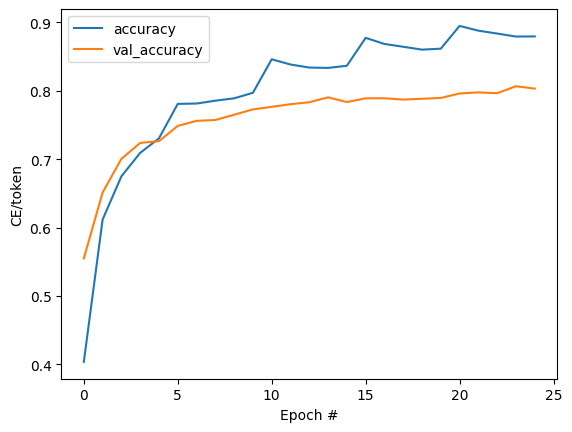

In [29]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [78]:
# x = [
#     "Hello world",
#     "Maksim break tensorflow",
#     "I am trying to run this model, but it is difficult to do",
#     "pugs are awesome",
#     "water is wet",
#     "Water is usually wet at all times when it's not rigid or gas",
#     "Happy Birthday to you Tom!",
#     "Hello WORLD! this is not end",
# ]
x =["Привіт світ",
    "З днем народження Томе",
    "Цей перекладач досить поганий",
    "Том молиться на курку",
    "курка несе яйця",
    "Я не їв шість днів",
    "Їжак це пацюк з голками",
    "Я хочу дати тобі яблуко",
    "Я маю добру душу"
   ]

In [31]:
print(tf.strings.reduce_join(model.translate(x), axis=-1,separator="\n").numpy().decode())

hi the world is    
pleased with tom     
this is quite bad at the beginning 
tom is going to have chicken pox 
chicken is high     
i haven't eaten six days   


In [ ]:
for i in range(len(x)):
    model.plot_attention(x[i], temperature=1.0)

In [33]:
# long_text = "Pugs were brought from China to Europe in the sixteenth century and "\
#             "were popularized in Western Europe by the House of Orange of the Netherlands, "\
#             "and the House of Stuart. In the United Kingdom, in the nineteenth century, "\
#             "Queen Victoria developed a passion for Pugs which she passed on to other members of the royal family."
# print(tf.strings.reduce_join(model.translate([long_text]), axis=-1,separator="\n").numpy().decode())
# model.plot_attention(long_text, temperature=0.0)

In [34]:
# model = CrossAttention(UNITS)
# model((rng.random((64,13,256)),rng.random((64,13,256))))
# inputs = keras.Input((5,5))
# x = keras.layers.Dense(12)(inputs)
# model = keras.Model(inputs,x)

In [35]:
model.save("my_translator_to_eng.keras")

2024-06-29 18:17:19.697114: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58152960 exceeds 10% of free system memory.
2024-06-29 18:17:19.903134: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58152960 exceeds 10% of free system memory.
2024-06-29 18:17:20.657870: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58152960 exceeds 10% of free system memory.


In [36]:
loaded_model = keras.models.load_model("my_translator_to_eng.keras")
# model = loaded_model

2024-06-29 18:17:50.654053: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58152960 exceeds 10% of free system memory.
2024-06-29 18:17:51.171152: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58152960 exceeds 10% of free system memory.


In [37]:
# print(tf.strings.reduce_join(loaded_model.translate(x), axis=-1,separator="\n").numpy().decode())

In [38]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string)])
    def translate(self, inputs):
        return self.model.translate(inputs)

In [35]:
# export = Export(model)

In [36]:
# tf.saved_model.save(export, "translator",signatures={"serving_default":export.translate})

In [37]:
# reloaded = tf.saved_model.load("translator")

In [79]:
print(tf.strings.reduce_join(loaded_model.translate(x), axis=-1,separator="\n").numpy().decode())
model = loaded_model

hi the world is     
pleased with tom      
this is quite bad at the beginning  
tom is going to have chicken pox  
chicken is high      
i haven't eaten six days    
is it a sentence since you are born 
i want to give you an apple  
i have a good shower    
